# Background sample
The goal is to choose the background sample that will be used to train the BDTs.
This will be the `common` data with a high mass cut on the $m(D^*)$-constrained $m(D^*3\pi)$, in order to keep only the combinatorial region.

In [1]:
name_data_MC = 'MC_constr_opposedCB_sharedMean'
name_data_KPiPi = "data_KPiPi_constr"

name_data = 'common_B0TODst3pi_Dst_constr'
name_data_B0toDstDs = 'common_B0TODstDs_Dst_constr'
name_data_Dstto3pi = 'common_DstTO3pi'

var = 'Dst_constr_B0_M'

In [2]:
import zfit
import timeit
import pandas as pd


from bd2dst3pi.locations import loc
from bd2dst3pi.definitions import years, magnets

import sys
sys.path.append(loc.SCRIPTS)
from load_save_data import load_data, load_saved_root, add_constr_Dst, json_to_latex_table, retrieve_params, save_dataframe
from plot.fit import plot_hist_fit_particle
import plot.histogram as h
from fit import launch_fit, define_zparams, save_params, sum_crystalball
from variables import name_params, name_params_B0toDstDs
from plot.tool import fix_plot, save_file
from plot.line import plot_x_list_ys
import numpy as np

Welcome to JupyROOT 6.22/02


## Load `common` data

In [3]:
df = {}
df['common'] = load_data(years,magnets,type_data = 'common'  ,vars = ['B0_M'], cut_DeltaM=True, cut_PIDK=None)

/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//common/data/data_90000000_2015_up.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//common/data/data_90000000_2015_down.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//common/data/data_90000000_2016_up.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//common/data/data_90000000_2016_down.root
cut on DeltaM has removed 425088 over 935261 events


In [4]:
df['common'] = add_constr_Dst(df['common'])

## Plot the constrained $m(D^* 3\pi)$

The cut is `low_bkg < constrained_B0_M < high_bkg`

In [5]:
low_bkg = 5400
high_bkg = 5570

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/B0_M_data_highmasscut


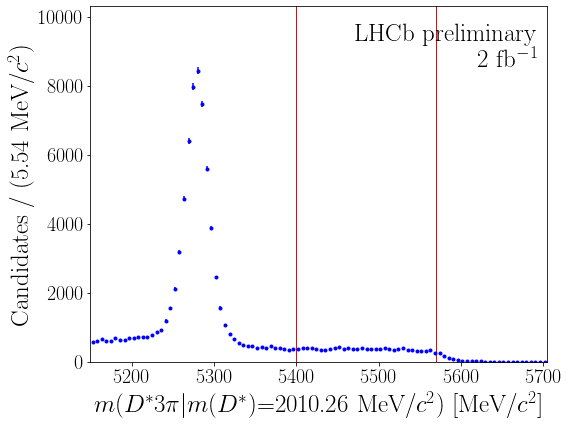

In [6]:
fig, ax = h.plot_hist_particle({'data':df['common']}, var,
              n_bins = 100, mode_hist = False, colors=['b'], low=5150, high=None, save_fig=False, pos_text_LHC='right')
ax.axvline(x=low_bkg, color='red', linewidth=1.)
ax.axvline(x=high_bkg, color='red', linewidth=1.)
save_file(fig, 'B0_M_data_highmasscut')

The high cut on $m(D^*3\pi|m(D^*)=m(D^*)_{PDG})$ is chosen to be $m(D^*3\pi|m(D^*)=m(D^*)_{PDG})<5570$ MeV/$c^2$ to avoid side effects.

We are going to compare the PDFs of the signal and combinatorial background components to choose the left cut.

## Load the fit to the constrained $m(D^* 3\pi)$

#### Variables of the PDFs

In [7]:
data_KPiPi_params = retrieve_params(name_data_KPiPi, name_folder='data_KPiPi') # already in MeV   
data_DstDs_params = retrieve_params(name_data_B0toDstDs, name_folder=name_data_B0toDstDs)   
MC_param_results = retrieve_params(name_data_MC, name_folder='MC')
data_params = retrieve_params(name_data, name_folder=name_data)

variables_data = ['mu', 'sigmaL', 'sigmaR', 'alphaL', 'alphaR', 'nL', 'frac', 'n_sig', 'lambda', 'n_bkg', 'r_bkgK']

initial_values = {}

for variable in variables_data:
    initial_values[variable] = {'value': data_params[variable], 'floating': True}
initial_values['nR'] = {'value': MC_param_results['nR_MC']     , 'floating': False}

for variable in 'muL', 'muR', 'sigmaL', 'sigmaR', 'nL', 'nR', 'alphaL', 'alphaR', 'nL', 'nR', 'fraction':
    initial_values[f'{variable}_K'] = {'value': data_KPiPi_params[variable], 'low': None, 'high': None, 'floating': False}

for variable in 'mu', 'sigma', 'n_sig' :
    initial_values[f'{variable}_Ds'] = {'value': data_DstDs_params[f'{variable}_DstDs'], 'low': None, 'high': None, 'floating': False}



zparams = define_zparams(initial_values)

# Composed parameter
mult = lambda r, n: r*n
zparams["n_bkgK"] = zfit.ComposedParameter("n_bkgK", mult, params=[zparams['r_bkgK'],zparams['n_sig']])

#### PDFs

In [8]:
low = 5150.
high = 5545.

obs = zfit.Space("x", limits=(low, high))

model_S, crystalBallL_S, crystalBallR_S = sum_crystalball(zparams['mu'], zparams['mu'],
                                                          zparams['sigmaL'], zparams['sigmaR'],
                                                          zparams['frac'], obs,                                                          
                                                          zparams['alphaL'], zparams['alphaR'], 
                                                          zparams['nL'], zparams['nR']
                                                         )


gaussian_Ds = zfit.pdf.Gauss(zparams['mu_Ds'],zparams['sigma_Ds'],obs=obs)

model_K, crystalBallL_K, crystalBallR_K = sum_crystalball(zparams['muL_K'], zparams['muR_K'], 
                                                          zparams['sigmaL_K'], zparams['sigmaR_K'],
                                                          zparams['fraction_K'], obs,
                                                          zparams['alphaL_K'], zparams['alphaR_K'], 
                                                          zparams['nL_K'], zparams['nR_K'])

exponential = zfit.pdf.Exponential(zparams['lambda'], obs=obs)


model_S_ext = model_S.create_extended(zparams['n_sig'])
exp_ext = exponential.create_extended(zparams['n_bkg'])
gaussian_Ds_ext = gaussian_Ds.create_extended(zparams['n_sig_Ds'])
model_K_ext = model_K.create_extended(zparams['n_bkgK'])

model = zfit.pdf.SumPDF([model_S_ext, gaussian_Ds_ext, model_K_ext, exp_ext]) # gauss is folded by frac


## Plots as a function of the low cut on $m(D^*3\pi|m(D^*)=m(D^*)_{PDG})$

The cut is: $m(D^*3\pi|m(D^*)=m(D^*)_{PDG})>b$

In [9]:
b = np.arange(5355, 5450, 5)
print(b)

[5355 5360 5365 5370 5375 5380 5385 5390 5395 5400 5405 5410 5415 5420
 5425 5430 5435 5440 5445]


#### $y(b) = \frac{n_{S} p_S (b)}{n_{B,c} p_{B,c} (b)}$ as a function of $b$

In [9]:
y = np.array((zparams['n_sig']/zparams['n_bkg'])*model_S_ext.pdf(b)/exp_ext.pdf(b))
print(y)

[0.09614861 0.07331473 0.05658796 0.04416617 0.03482511 0.02771934
 0.02225623 0.01801453 0.01469095 0.01206457 0.0099726  0.00829392
 0.00693748 0.00583425 0.00493145 0.00418836 0.0035734  0.00306182
 0.00263416]


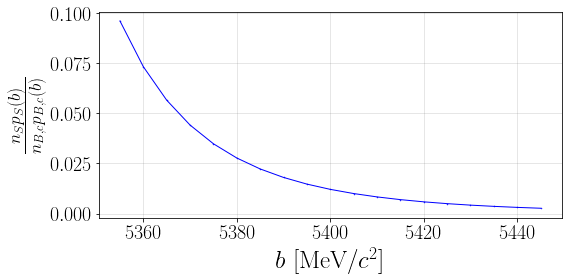

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/BDT/gradient/purity_bkg_sample


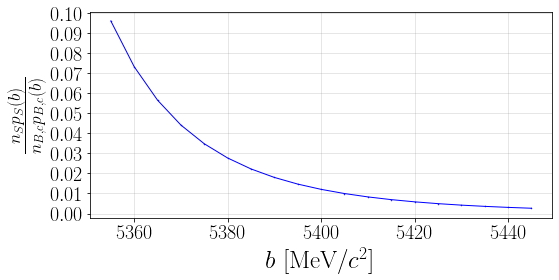

In [26]:
fig, ax = plot_x_list_ys(b, y, '$b$ [MeV/$c^2$]', 
               ['frac'], surnames_y=['$\\frac{n_{S} p_{S}(b)}{n_{B,c} p_{B,c}(b)}$'],
               name_folder=name_data, save_fig=False)
from matplotlib.ticker import MultipleLocator
ax.yaxis.set_major_locator(MultipleLocator(.01))
save_file(fig, 'purity_bkg_sample', name_folder='BDT/gradient')
fig

In [29]:
value_b = 5400

i = 0
while b[i] != value_b and i<len(b):
    i+=1
    
print(f"Relative quantity of signal at b = {value_b}: {y[i]}")   

Relative quantity of signal at b = 5400: 0.012064567564740636


#### $n_{S\in \text{bkg}}(b) = \int_{b}^{5570} dx\, n_{S} p_{S}(x)$ (number of signal events in the background sample) as a function of $b$

In [11]:
nS_in_B = []

for be in b:
    nS_in_B.append(float(zparams['n_sig']*model_S_ext.analytic_integrate([be, high_bkg])))
nS_in_B = np.array(nS_in_B)  

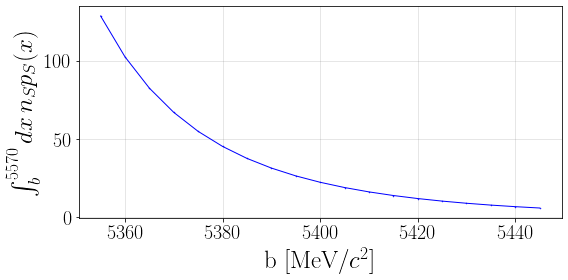

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/common_B0TODst3pi_Dst_constr/b_[MeVdc^2]_vs_nS_in_B


(<Figure size 576x288 with 1 Axes>,
 <AxesSubplot:xlabel='b [MeV/$c^2$]', ylabel='$\\int_{b}^{5570} dx\\, n_{S} p_{S}(x)$'>)

In [17]:
plot_x_list_ys(b, nS_in_B, 'b [MeV/$c^2$]',
               ['nS_in_B'], surnames_y=['$\\int_{b}^{5570} dx\\, n_{S} p_{S}(x)$'],
               name_folder=name_data)

#### $n_{\text{bkg}}(b) = \int_{b}^{5570} dx\, n_{b,c} p_{b,c}(x)$ (number of bakcground events in the background sample) as a function of $b$

In [18]:
z = []
for be in b:
    z.append(len(df['common'].query(f'{var}>{be}')))
z = np.array(z)

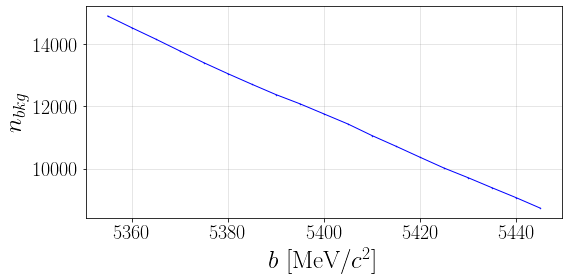

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/common_B0TODst3pi_Dst_constr/b_[MeVdc^2]_vs_n_bkg


(<Figure size 576x288 with 1 Axes>,
 <AxesSubplot:xlabel='$b$ [MeV/$c^2$]', ylabel='$n_{bkg}$'>)

In [19]:
plot_x_list_ys(b, z, '$b$ [MeV/$c^2$]', 
               ['n_bkg'], surnames_y=['$n_{bkg}$'],
               name_folder=name_data)

The background sample for the training of the BDT is the `common` data with 5400 MeV/$c^2$ $< m(D^*3\pi|m(D^*)=m(D^*)_{PDG}) < 5570$ MeV/$c^2$

Thanks to this cut ($b=5400 MeV/c^2$), $y(b) = \frac{n_{S} p_S (b)}{n_{B,c} p_{B,c} (b)}=1.2\%$; the background sample is highly pure in background events.

## Final plot showing the cut for the background data

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/common_B0TODst3pi_Dst_constr/Dst_constr_B0_M_common_B0TODst3pi_Dst_constr_bkg_fit_full


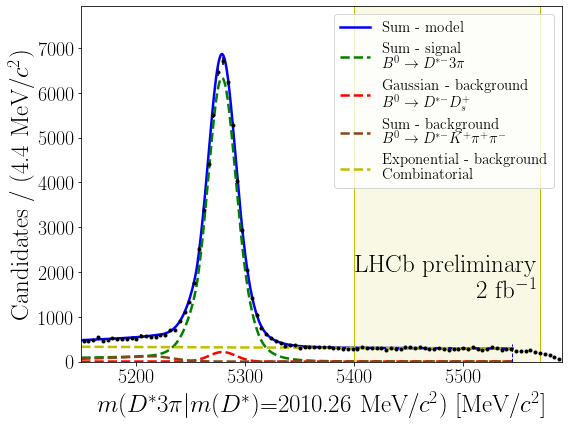

In [12]:
fig, ax = plot_hist_fit_particle(df['common'], var, models = [model, model_S_ext, gaussian_Ds_ext, model_K_ext,exp_ext],
                      name_models = ["", '\n $B^0\\to D^{*-} 3\pi$','\n $B^0\\to D^{*-}D_s^+$',
                                      '\n $B^0\\to D^{*-} K^+ \pi^+\pi^-$','\n Combinatorial'],
                       obs=obs, n_bins = 100,mode_hist=False, high_hist=5590,
                       name_data = name_data+'_bkg', name_folder=name_data,
                       colors=['b','g','r','saddlebrown','y'], loc_leg='best',
                       fontsize_leg=15., pos_text_LHC=[0.95, 0.30, 'right'],
                       plot_pull=False, save_fig=False)

ax.axvspan(low_bkg, high_bkg, alpha=0.1, color='y')
ax.axvline(x=5545, ymax=0.05, color='b', linewidth=1., linestyle='--')
ax.axvline(x=low_bkg, color='y', linewidth=1., linestyle='-')
ax.axvline(x=high_bkg, color='y', linewidth=1., linestyle='-')

save_file(fig, "Dst_constr_B0_M_common_B0TODst3pi_Dst_constr_bkg_fit_full", name_folder='common_B0TODst3pi_Dst_constr')

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/common_B0TODst3pi_Dst_constr/Dst_constr_B0_M_common_B0TODst3pi_Dst_constr_bkg_fit


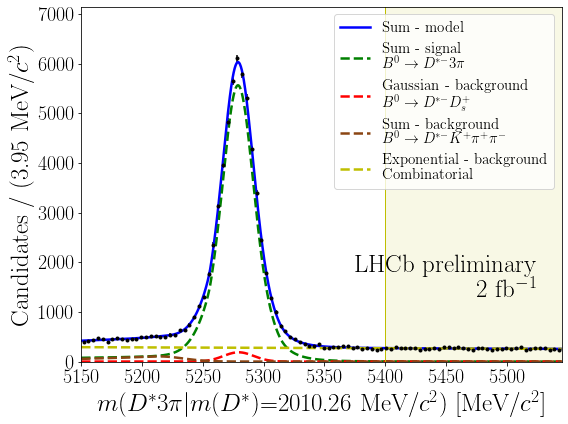

In [13]:
fig, ax = plot_hist_fit_particle(df['common'], var, models = [model, model_S_ext, gaussian_Ds_ext, model_K_ext,exp_ext],
                      name_models = ["", '\n $B^0\\to D^{*-} 3\pi$','\n $B^0\\to D^{*-}D_s^+$',
                                      '\n $B^0\\to D^{*-} K^+ \pi^+\pi^-$','\n Combinatorial'],
                       obs=obs, n_bins = 100,mode_hist=False,
                       name_data = name_data+'_bkg', name_folder=name_data,
                       colors=['b','g','r','saddlebrown','y'], loc_leg='best',
                       fontsize_leg=15., pos_text_LHC=[0.95, 0.30, 'right'],
                       plot_pull=False, save_fig=False)

ax.axvspan(low_bkg, high_bkg, alpha=0.1, color='y')
ax.axvline(x=5545, ymax=0.05, color='b', linewidth=1., linestyle='--')
ax.axvline(x=low_bkg, color='y', linewidth=1., linestyle='-')
ax.axvline(x=high_bkg, color='y', linewidth=1., linestyle='-')

save_file(fig, "Dst_constr_B0_M_common_B0TODst3pi_Dst_constr_bkg_fit", name_folder='common_B0TODst3pi_Dst_constr')